In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [4]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

#### Fill in the missing values

In [5]:
df = df.fillna(0)

In [6]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

#### Train/Test/Split

In [7]:
df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=1)
df_train, df_val =train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

df_train =df_train.reset_index(drop=True)
df_val =df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

#### Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [8]:
dv = DictVectorizer(sparse=True)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

##### Question 1 . Let's train a decision tree regressor to predict the fuel_efficiency_mpg variable.

###### Train a model with max_depth=1.

In [9]:
### Train a simple Decision Tree Regressor with max_depth = 1 and see which feature it splits on first.
####That “first split” tells you which feature is most important for predicting fuel efficiency.

# Train the simplest tree
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train, y_train)

feature_names = dv.get_feature_names_out()
importance = dt.feature_importances_

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

df_importance.head(1)


,feature,importance
13,vehicle_weight,1.0


#### Train a random forest regressor with these parameters:

##### n_estimators=10
##### random_state=1
##### n_jobs=-1 (optional - to make training faster)

In [10]:
# What's the RMSE of this model on the validation data?

rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.4595777223092726


#### Question 3

#### Find how many trees (n_estimators) we need before performance stops getting better.

In [11]:
#Now let's experiment with the n_estimators parameter

# -Try different values of this parameter from 10 to 200 with step 10.
# - Set random_state to 1.
# - Evaluate the model on the validation dataset.


scores = []

for n in range(10, 201, 10):  # from 10 to 200, step = 10
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, rmse))

# Display the results
for n, s in scores:
    print(f"n_estimators={n}: RMSE={s:.3f}")

n_estimators=10: RMSE=0.460
n_estimators=20: RMSE=0.454
n_estimators=30: RMSE=0.452
n_estimators=40: RMSE=0.449
n_estimators=50: RMSE=0.447
n_estimators=60: RMSE=0.445
n_estimators=70: RMSE=0.445
n_estimators=80: RMSE=0.445
n_estimators=90: RMSE=0.445
n_estimators=100: RMSE=0.445
n_estimators=110: RMSE=0.444
n_estimators=120: RMSE=0.444
n_estimators=130: RMSE=0.444
n_estimators=140: RMSE=0.443
n_estimators=150: RMSE=0.443
n_estimators=160: RMSE=0.443
n_estimators=170: RMSE=0.443
n_estimators=180: RMSE=0.442
n_estimators=190: RMSE=0.442
n_estimators=200: RMSE=0.442


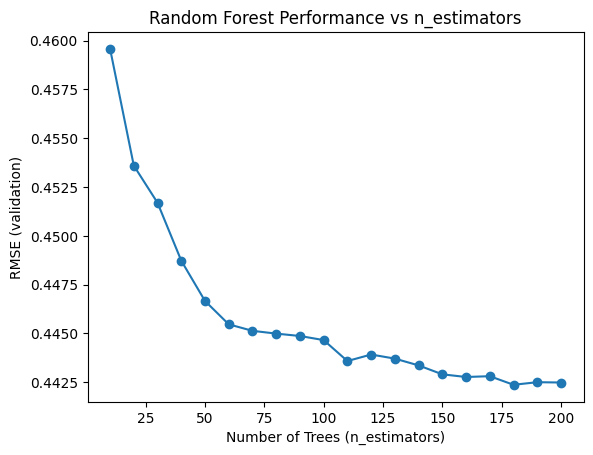

In [12]:
x = [n for n, _ in scores]
y = [s for _, s in scores]

plt.plot(x, y, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('RMSE (validation)')
plt.title('Random Forest Performance vs n_estimators')
plt.show()

#### Question 4 .What's the best max_depth, using the mean RMSE?

In [13]:
# Try different values of max_depth: [10, 15, 20, 25]
# For each of these values,
    #try different values of n_estimators from 10 till 200 (with step 10)
    #calculate the mean RMSE
# Fix the random seed: random_state=1

max_depth_values = [10, 15, 20, 25]
results = {}

for depth in max_depth_values:
    rmses = []
    for n in range(10, 201, 10):  # 10, 20, 30, ..., 200
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=depth,
            random_state=1,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
    
    mean_rmse = np.mean(rmses)
    results[depth] = mean_rmse
    print(f"max_depth={depth}: mean RMSE={mean_rmse:.3f}")

max_depth=10: mean RMSE=0.442
max_depth=15: mean RMSE=0.445
max_depth=20: mean RMSE=0.446
max_depth=25: mean RMSE=0.446


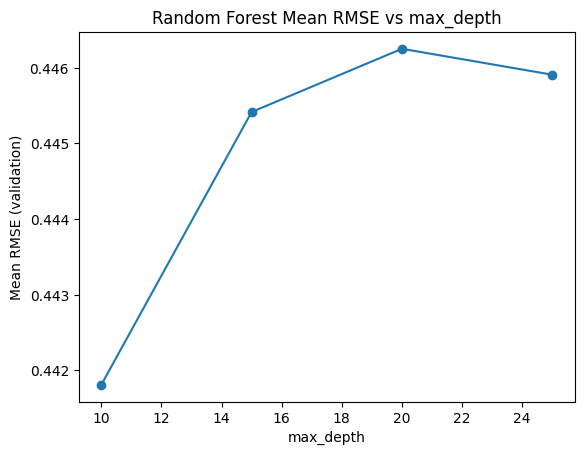

In [14]:
plt.plot(results.keys(), results.values(), marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean RMSE (validation)')
plt.title('Random Forest Mean RMSE vs max_depth')
plt.show()

#### Question 5 — Finding the Most Important Feature

In [15]:
### Train a Random Forest model and check which features the model relies on most.

# Train the model
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Extract feature importance
feature_names = dv.get_feature_names_out()
importances = rf.feature_importances_

# Combine into a dataframe
df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(df_importance.head(10))

                feature  importance
13       vehicle_weight    0.959150
6            horsepower    0.015998
0          acceleration    0.011480
3   engine_displacement    0.003273
7            model_year    0.003212
8         num_cylinders    0.002343
9             num_doors    0.001635
12           origin=USA    0.000540
11        origin=Europe    0.000519
10          origin=Asia    0.000462
